In [1]:
%load_ext autoreload
%autoreload 2

from src import *

In [32]:
file = '001_Benatska_ESP32'
uuid = '036_aligned_resized_128_audio_image_augmentation_bs_256/4'

# rvce | mae | last
model_name = 'rvce'
from_time, till_time = 0 * 60, 5 * 60

model, config = load_model_locally(uuid, model_name=model_name, device='cpu')
video = Video(file, config)
# predictions, probabilities = {'n_counts': None}, {'n_counts': None}
predictions, probabilities = validate_video(video, model, from_time=from_time, till_time=till_time, return_probs=True)

file "data/labels/**/001_Benatska_ESP32.txt" does not exist
file "data/csv/**/001_Benatska_ESP32.csv" does not exist


In [33]:
# predictions['n_counts']
# events = video.events
# mask = (events >= from_time) & (events < till_time)
# events[mask]

In [34]:
predictions['n_counts'].sum()

25

00:00 - 05:00


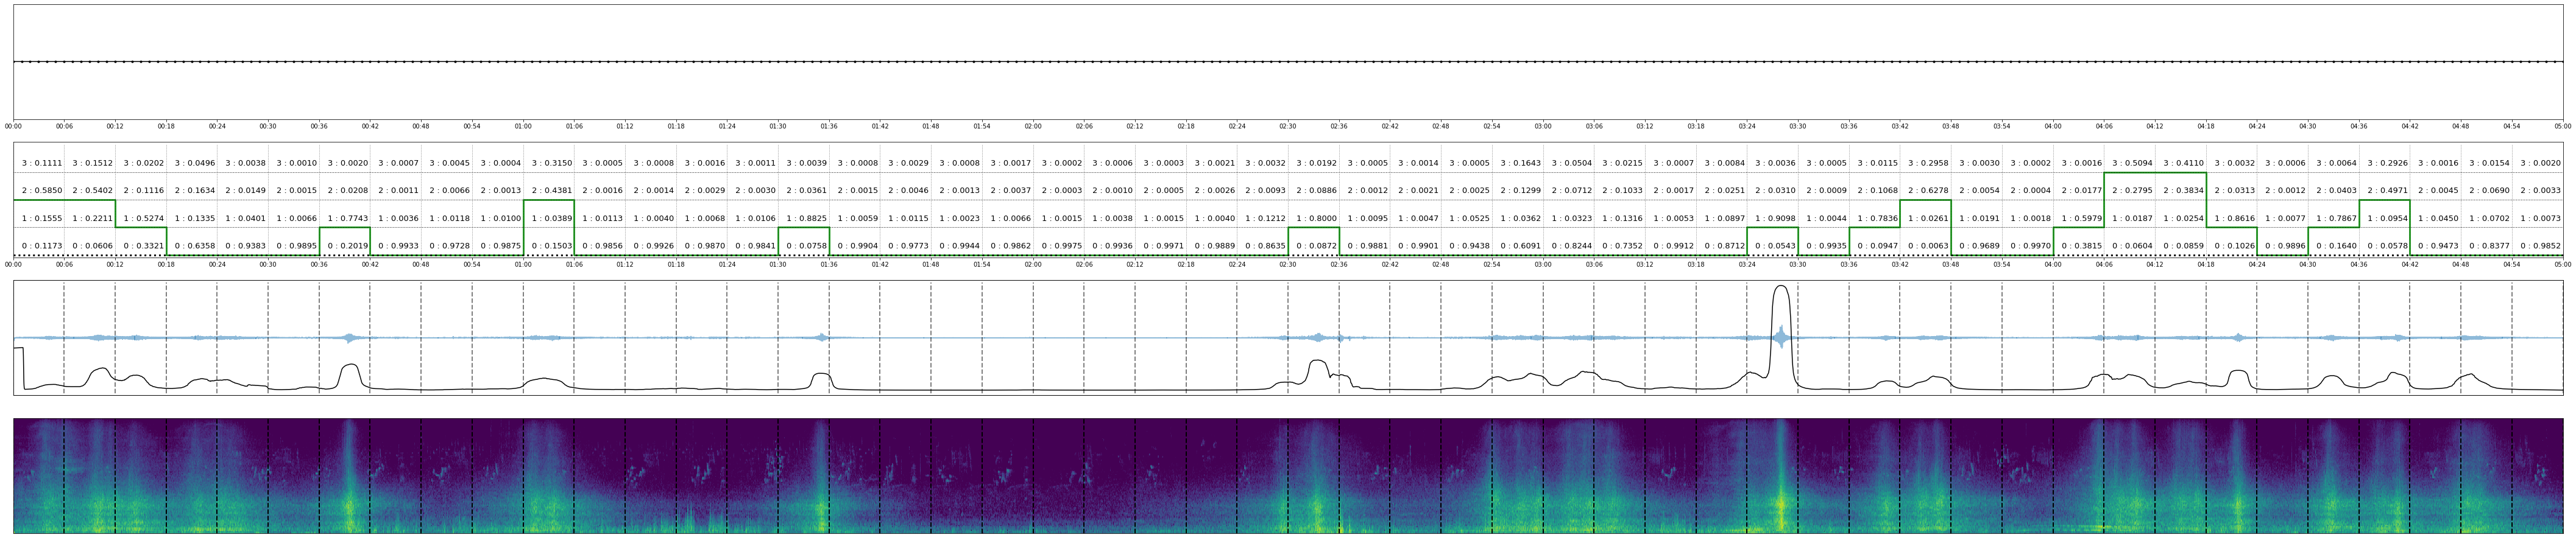

In [44]:
show(
    config,
    signal=video.signal,
    best_detection_frame=None, 
    predictions=predictions['n_counts'],
    probabilities=probabilities['n_counts'],
    events_start_time=video.events_start_time,
    events_end_time=video.events_end_time,
    events=video.events,
    views=video.views,
    from_time=from_time,
    till_time=till_time,
    # save='plots/visualization.png',
    # save=False,
    # plot_true_features=True
)
show_video(file)

In [ ]:
dataset = 'config/dataset/30.03.2022_cvut_clean.yaml'

uuid = '010_cvut_dataset/0'
model_name = 'rvce'
from_time, till_time = 0 * 60, 4 * 60

with open(dataset, 'r') as stream:
    files = yaml.safe_load(stream)

for i, file in enumerate(files):
    config = load_config_locally(uuid)
    video = Video(file, config)
    
    show(
        config,
        signal=video.signal,
        best_detection_frame=None, 
        predictions=None,
        probabilities=None,
        events_start_time=video.events_start_time,
        events_end_time=video.events_end_time,
        events=video.events,
        views=video.views,
        from_time=from_time,
        till_time=till_time,
        # save=False,
        save=f'plots/dataset_vis_30.03.2022_cvut/{file}.png',
        # plot_true_features=True
    )